# [import dependencies]()

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os

import tensorflow as tf

from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv2D,
    BatchNormalization,
    MaxPooling2D,
    Dropout,
    GlobalAveragePooling2D,
    GlobalAveragePooling3D,
)

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))

2.17.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# [Read Data]()

In [3]:
# get the path of the annotations file
train_path = (
    "/home/hany_jr/Ai/Egyption-Hieroglyphs-detection/dataset/Egyptian Hieroglyphs/train"
)

# load the annotations csv file
annotations = pd.read_csv(train_path + "/_annotations.csv")

annotations.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,nile-fish-7-_jpg.rf.31e4278980878c47a1e6a2f8dd...,640,640,Nile_Fish,375,319,512,454
1,Her-8-_jpg.rf.32bcf63f4ae4d6aea53cea5b9c0059b4...,640,640,Her,211,247,368,339
2,composite_bow-34-_jpg.rf.33153e63f7158777c50d4...,640,640,Composite_Bow,158,183,336,282
3,snake-6-_jpg.rf.32ac52ece4bcc06b1ead936693df17...,640,640,Snake,181,351,318,506
4,king-26-_jpg.rf.329a5a8e366f4fe2e3a3dca88524cc...,640,640,King,218,290,339,524


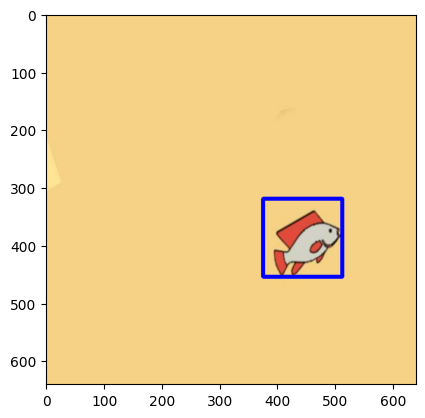

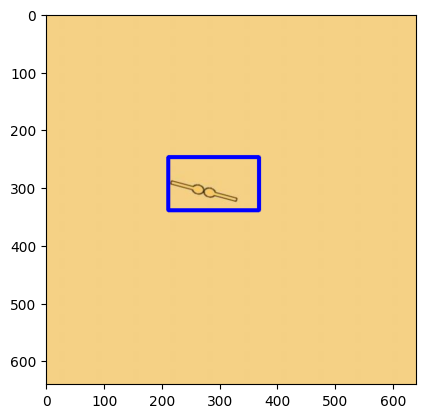

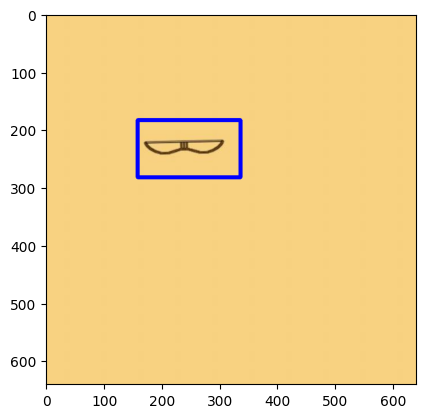

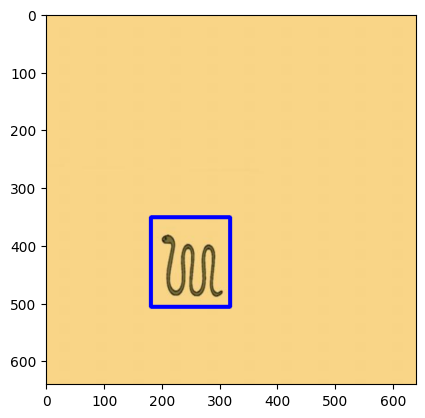

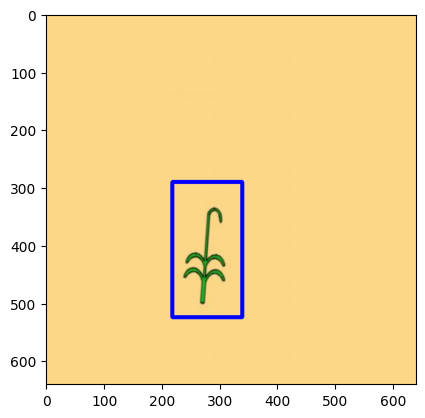

In [4]:
for i in range(0, 5):
    image_path = train_path + "/" + annotations["filename"][i]

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    x1 = annotations.iloc[i, 4]
    y1 = annotations.iloc[i, 5]
    x2 = annotations.iloc[i, 6]
    y2 = annotations.iloc[i, 7]

    img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 5)

    plt.imshow(img)
    plt.show()

### Note:

we can use the annotations to crop the images and create a new dataset with the cropped images, by using bounding box coordinates.
by doing that we will make the model:
1. focus on the hieroglyphs only and ignore the background.
2. reduce the size of the images and make the model faster to train.

# [Data Cropping]()

In [49]:
classes = annotations["class"].unique()
classes = np.sort(classes)
# create a directory for each class in the dataset
train_path = (
    "/home/hany_jr/Ai/Egyption-Hieroglyphs-detection/dataset/Cropped data/train"
)
for _class in classes:
    os.makedirs(train_path + "/" + _class.lower(), exist_ok=True)

In [50]:
current_dir_size = 0


def crop_and_save_images(dataframe, path):
    global current_dir_size

    for i in range(len(dataframe)):

        image_path = path + "/" + dataframe["filename"][i]

        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # get the coordinates of the bounding box
        x1 = dataframe.iloc[i, 4]
        y1 = dataframe.iloc[i, 5]
        x2 = dataframe.iloc[i, 6]
        y2 = dataframe.iloc[i, 7]

        # crop the image and resize it to 224x224

        cropped_image = cv2.resize(img[y1:y2, x1:x2], (224, 224))

        # write the image in the cropped folder
        train_croped_path = (
            "/home/hany_jr/Ai/Egyption-Hieroglyphs-detection/dataset/Cropped data/train"
        )

        # get the directory name to save the image in the correct folder
        dirictory = dataframe.iloc[i, 0].split("-")[0].lower()

        # save the image in the correct folder
        cv2.imwrite(
            train_croped_path
            + "/"
            + dirictory
            + "/"
            + dirictory
            + "-"
            + str(current_dir_size)
            + ".jpg",
            cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR),
        )

        current_dir_size += 1
        """    
            plt.imshow(cropped_image)
            plt.show()
        """


# crop and save the images for the training set
path = (
    "/home/hany_jr/Ai/Egyption-Hieroglyphs-detection/dataset/Egyptian Hieroglyphs/train"
)
crop_and_save_images(annotations, path)

In [51]:
# add validation data to the training data to make the model generalize better

# load the validation data
val_annotations = pd.read_csv(
    "/home/hany_jr/Ai/Egyption-Hieroglyphs-detection/dataset/Egyptian Hieroglyphs/valid/_annotations.csv"
)

val_annotations.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,hit-29-_jpg.rf.0002460aa57927fd78f439dfae18698...,640,640,Hit,204,177,355,371
1,this-21-_jpg.rf.00392809c20fae35e692ba71dcb8a5...,640,640,This,170,213,282,369
2,turtle-15-_jpg.rf.00ca6ad63e61fc66d330c698e50e...,640,640,Turtle,280,247,425,399
3,mascot-20-_jpg.rf.0100543269029e643b6351c66771...,640,640,Mascot,117,315,283,482
4,meet-26-_jpg.rf.015f393754837d733509c11522977a...,640,640,Meet,214,192,358,351


In [52]:
path = (
    "/home/hany_jr/Ai/Egyption-Hieroglyphs-detection/dataset/Egyptian Hieroglyphs/valid"
)
crop_and_save_images(val_annotations, path)

# [Prepare Data for the model]()

In [5]:
path = "/home/hany_jr/Ai/Egyption-Hieroglyphs-detection/dataset/Cropped data/train"
generator = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1 / 255.0,
    preprocessing_function=None,
    validation_split=0.1,
).flow_from_directory(
    path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    color_mode="rgb",
    subset="training",
)

Found 2705 images belonging to 95 classes.


In [6]:
generator.class_indices

{'100': 0,
 'among': 1,
 'angry': 2,
 'ankh': 3,
 'aroura': 4,
 'at': 5,
 'bad_thinking': 6,
 'bandage': 7,
 'bee': 8,
 'belongs': 9,
 'birth': 10,
 'board_game': 11,
 'book': 12,
 'boy': 13,
 'branch': 14,
 'bread': 15,
 'brewer': 16,
 'builder': 17,
 'bury': 18,
 'canal': 19,
 'cloth_on_pole': 20,
 'cobra': 21,
 'composite_bow': 22,
 'cooked': 23,
 'corpse': 24,
 'dessert': 25,
 'divide': 26,
 'duck': 27,
 'elephant': 28,
 'enclosed_mound': 29,
 'eye': 30,
 'fabric': 31,
 'face': 32,
 'falcon': 33,
 'fingre': 34,
 'fish': 35,
 'flail': 36,
 'folded_cloth': 37,
 'foot': 38,
 'galena': 39,
 'giraffe': 40,
 'he': 41,
 'her': 42,
 'hit': 43,
 'horn': 44,
 'king': 45,
 'leg': 46,
 'length_of_a_human_arm': 47,
 'life_spirit': 48,
 'limit': 49,
 'lion': 50,
 'lizard': 51,
 'loaf': 52,
 'loaf_of_bread': 53,
 'man': 54,
 'mascot': 55,
 'meet': 56,
 'mother': 57,
 'mouth': 58,
 'musical_instrument': 59,
 'nile_fish': 60,
 'not': 61,
 'now': 62,
 'nurse': 63,
 'nursing': 64,
 'occur': 65,
 'one

# [Model]()

In [48]:
input_layer = tf.keras.Input(shape=(224, 224, 3), name="input_layer")

first_layer = Conv2D(32, 3, activation="relu", name="first_layer")(input_layer)
pool_layer1 = MaxPooling2D(name="pool_layer1")(first_layer)

second_layer = Conv2D(64, 3, activation="relu", name="second_layer")(pool_layer1)
pool_layer2 = MaxPooling2D(name="pool_layer2")(second_layer)

third_layer = Conv2D(128, 3, activation="relu", name="this_layer")(pool_layer2)
pool_layer3 = MaxPooling2D(name="pool_layer3")(third_layer)

normalization = BatchNormalization(name="normalization")(pool_layer3)

flatten = Flatten(name="flatten")(normalization)

dense1 = Dense(256, activation="relu", name="dense1")(flatten)
dropout1 = Dropout(0.2, name="dropout1")(dense1)

dense2 = Dense(128, activation="relu", name="dense2")(dropout1)
dropout2 = Dropout(0.2, name="dropout2")(dense2)

dense2 = Dense(32, activation="relu", name="dense3")(dropout2)


output = Dense(len(generator.class_indices), activation="softmax", name="output")(
    dense2
)

model = tf.keras.Model(inputs=input_layer, outputs=output)

model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ first_layer (Conv2D)            │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_layer1 (MaxPooling2D)      │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_layer (Conv2D)           │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_layer2 (MaxPooling2D)      │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ this_layer (Conv2D)             │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_layer3 (MaxPooling2D)      │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization                   │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense3 (Dense)                  │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 95)             │         3,135 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,285,343 (85.01 MB)

 Trainable params: 22,285,087 (85.01 MB)

 Non-trainable params: 256 (1.00 KB)

In [49]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    "best_model.keras", monitor="val_loss", save_best_only=True
)

model_ReduceLROnPlateau = ReduceLROnPlateau(
    monitor="val_loss", factor=0.1, patience=15, min_lr=0.000001
)

callbacks = [early_stopping, model_checkpoint, model_ReduceLROnPlateau]

In [50]:
model.compile(
    optimizer=Adam(),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.fit(generator, epochs=50, callbacks=callbacks)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.0940 - loss: 4.1535 - learning_rate: 0.0010
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5038 - loss: 1.9443 - learning_rate: 0.0010
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.7325 - loss: 0.9614 - learning_rate: 0.0010
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8388 - loss: 0.5663 - learning_rate: 0.0010
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8934 - loss: 0.3640 - learning_rate: 0.0010
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8774 - loss: 0.4056 - learning_rate: 0.0010
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9021 - loss: 0.3337 - learning_rate: 0.0010
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9214 - loss: 0.2837 - learning_rate: 0.0010
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9394 - loss: 0.2212 - learning_rate: 0.0010
Epoch 10/50
85/85 ━

In [66]:
resnet = tf.keras.applications.ResNet101(
    weights="imagenet",
    include_top=False,
    input_shape=[224, 224, 3],
    pooling="avg",
)

resnet.trainable = False

resnet_model = tf.keras.Sequential(
    [
        resnet,
        BatchNormalization(),
        Flatten(),
        Dense(256, activation="relu"),
        Dropout(0.15),
        Dense(128, activation="relu"),
        Dropout(0.15),
        Dense(32, activation="relu"),
        Dense(len(generator.class_indices), activation="softmax"),
    ]
)

resnet_model.compile(
    optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"]
)
resnet_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)          │ (None, 2048)           │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 95)             │         3,135 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,231,071 (164.91 MB)

 Trainable params: 568,799 (2.17 MB)

 Non-trainable params: 42,662,272 (162.74 MB)

In [68]:
resnet_model.fit(generator, epochs=50, callbacks=callbacks)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.0730 - loss: 4.2075 - learning_rate: 0.0010
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.3651 - loss: 2.3969 - learning_rate: 0.0010
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.5892 - loss: 1.3845 - learning_rate: 0.0010
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.7490 - loss: 0.8391 - learning_rate: 0.0010
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.7938 - loss: 0.6650 - learning_rate: 0.0010
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.8653 - loss: 0.4857 - learning_rate: 0.0010
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.8762 - loss: 0.4230 - learning_rate: 0.0010
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.8866 - loss: 0.3550 - learning_rate: 0.0010
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.9094 - loss: 0.2810 - learning_rate: 0.0010
Epoch 10/50
85/85

In [69]:
resnet_model.save("./../model/ResNetModel.keras")
model.save("./../model/MyModel.keras")